In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [3]:
# 2. Load transaction data
df = pd.read_csv('data.csv', encoding='unicode_escape')
df.head()
# Expect fields: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# 3. Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[(df.Quantity > 0) & (df.UnitPrice > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [5]:
# 4. RFM Feature Engineering
snapshot = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'})
rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'}, inplace=True)

In [6]:
# 5. Outlier Handling (optional)
for col in ['Recency','Frequency','Monetary']:
    upper = rfm[col].mean() + 3*rfm[col].std()
    lower = max(rfm[col].mean() - 3*rfm[col].std(), 0)
    rfm = rfm[(rfm[col] >= lower) & (rfm[col] <= upper)]

In [7]:
# 6. Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

In [8]:
# 7. Optimal K via Elbow Plot
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

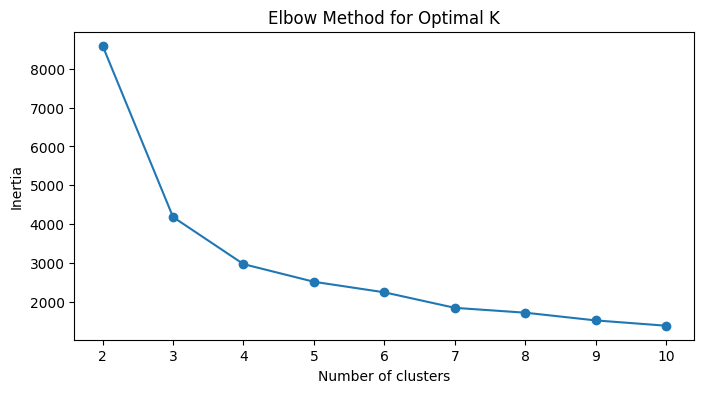

In [9]:
plt.figure(figsize=(8,4))
plt.plot(range(2,11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [10]:
# 8. K-Means clustering (choose k from elbow; e.g., 4)
k = 4
km = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = km.fit_predict(rfm_scaled)

In [11]:
# 9. Cluster Profiling
cluster_profiles = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Cluster':'size'
}).rename(columns={'Cluster':'Count'}).reset_index()
print(cluster_profiles)

   Cluster     Recency  Frequency     Monetary  Count
0        0   51.750225   2.257426   676.009272   2222
1        1  252.848963   1.474827   430.895736   1013
2        2   18.650943  15.306604  7235.149340    212
3        3   30.319803   7.002460  2668.946027    813


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17372\1854659152.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=cluster_profiles, palette='Blues_d')


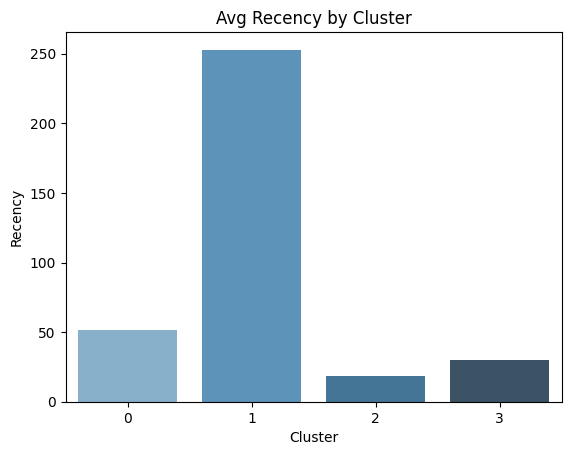

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17372\1854659152.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Frequency', data=cluster_profiles, palette='Greens_d')


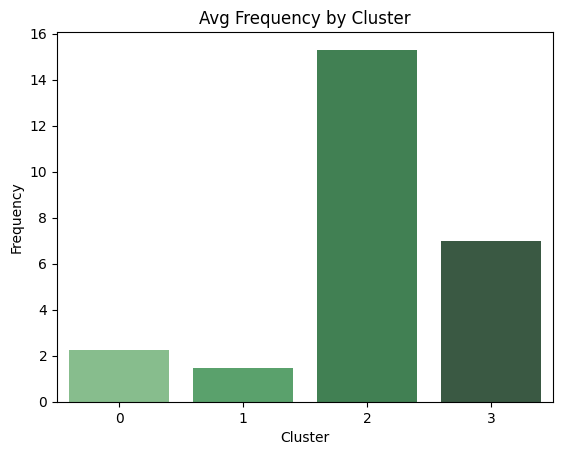

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17372\1854659152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Monetary', data=cluster_profiles, palette='Oranges_d')


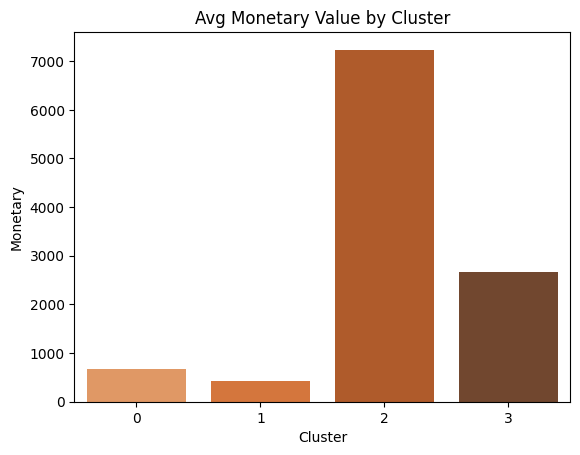

In [12]:
# 10. Visualization
sns.barplot(x='Cluster', y='Recency', data=cluster_profiles, palette='Blues_d')
plt.title('Avg Recency by Cluster'); plt.show()

sns.barplot(x='Cluster', y='Frequency', data=cluster_profiles, palette='Greens_d')
plt.title('Avg Frequency by Cluster'); plt.show()

sns.barplot(x='Cluster', y='Monetary', data=cluster_profiles, palette='Oranges_d')
plt.title('Avg Monetary Value by Cluster'); plt.show()